In [1]:
# !pip install torch==1.11.0+cpu torchvision==0.12.0+cpu torchaudio==0.11.0+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
# !pip install functorch

# print("--> Restarting colab instance") 
# get_ipython().kernel.do_shutdown(True)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torchmetrics import Accuracy

from functorch import make_functional_with_buffers, grad

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    )
])

batch_size = 64
device = "cuda"

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

Files already downloaded and verified
Files already downloaded and verified


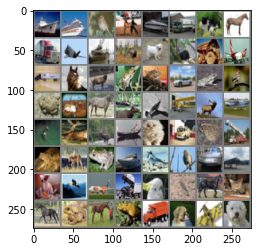

ship  ship  bird  horse ship  truck cat   horse truck plane ship  deer  dog   bird  truck plane truck horse deer  frog  cat   car   frog  bird  frog  deer  horse deer  plane plane deer  plane deer  deer  deer  ship  cat   truck frog  truck frog  deer  frog  ship  bird  bird  car   plane dog   bird  plane truck bird  bird  horse cat   horse frog  horse frog  truck dog   plane dog  


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [17]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn = nn.BatchNorm1d(16 * 5 * 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn(torch.flatten(x, 1))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Stateful PyTorch

In [18]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [19]:
def to_device(tensors, device="cpu"):
    "Put tensors on device"
    if isinstance(tensors, (list, tuple)):
        return tuple(to_device(t, device) for t in tensors)
    elif isinstance(tensors, torch.Tensor):
        return tensors.to(device)
    else:
        raise Exception("Not a torch tensor-ish")

In [21]:
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
metric = Accuracy().to(device)

In [29]:
for epoch in tqdm(range(5)):  # loop over the dataset multiple times
    metric.reset()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = to_device(data, device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        acc = metric(outputs, labels)

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch}] loss: {running_loss / 2000:.3f}, accuracy: {metric.compute():.3f}')

print('Finished Training')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[0] loss: 0.436, accuracy: 0.607


  0%|          | 0/782 [00:00<?, ?it/s]

[1] loss: 0.435, accuracy: 0.607


  0%|          | 0/782 [00:00<?, ?it/s]

[2] loss: 0.435, accuracy: 0.609


  0%|          | 0/782 [00:00<?, ?it/s]

[3] loss: 0.433, accuracy: 0.609


  0%|          | 0/782 [00:00<?, ?it/s]

[4] loss: 0.431, accuracy: 0.612
Finished Training


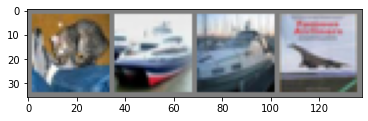

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Functional PyTorch

In [5]:
def sgd_optimizer(weights, gradients, learning_rate):
    return [weight - learning_rate * gradient for weight, gradient in zip(weights, gradients)]

In [6]:
model = Classifier().to(device=device)
functional_model, params, buffers = make_functional_with_buffers(model)

In [7]:
def compute_stateless_loss(params, buffers, sample, label):
    # sample = sample.unsqueeze(0)
    # label = label.unsqueeze(0)
    output = functional_model(params, buffers, sample)
    loss = F.cross_entropy(output, label)
    return loss


compute_gradients = grad(compute_stateless_loss)

In [8]:
def functional_step(params, buffers, sample, label):
    gradients = compute_gradients(params, buffers, sample, label)
    updated_params = sgd_optimizer(params, gradients, 1e-3)
    return updated_params

In [9]:
def train(train_step_fn, params, buffers):
    for i, data in tqdm(enumerate(train_loader, 0)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        params = train_step_fn(params, buffers, inputs, labels)
    return params

In [10]:
for epoch in range(2):
    weights = train(functional_step, params, buffers)

6250it [00:22, 278.85it/s]
6250it [00:20, 302.09it/s]


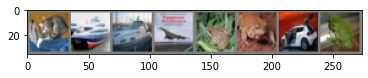

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 


In [13]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))